In [18]:
from gensim import corpora
import numpy as np
import pandas as pd
import spacy
import re
import string
import gensim

In [2]:
company_df = pd.read_csv("data/company_desc_translated.csv", sep=";")[["company_name", "description_en"]]

In [3]:
company_df

,company_name,description_en
0,Le Fourgon,Le Fourgon delivers your stored drinks to your...
1,Comptoir des Vignes,Comptoir des Vignes is a brand of cellars spec...
2,Shin Sekai,Welcome to our Trustpilot page! Shin Sekai is ...
3,Nutri Naturel,"Nutri-Naturel.com, the leading online organic ..."
4,Maison Martin - Le Piment Français,Maison Martin - Le Piment Francais is the firs...
...,...,...
12991,Ljbautoparts,"Sale of auto body spare parts online: fender, ..."
12992,Aéroports de Paris,"Aeroports de Paris, with its three platforms, ..."
12993,Online SAS,"Shared hosting with unlimited traffic, domain ..."
12994,shopequitation,Online specialist in the sale of horse riding ...


In [13]:
company_df.isnull().sum()

company_name         1
description_en    1528
dtype: int64

In [14]:
company_df = company_df.dropna(ignore_index=True)

In [15]:
company_df.isnull().sum()

company_name      0
description_en    0
dtype: int64

In [16]:
from spacy.lang.en.stop_words import STOP_WORDS

spacy_nlp = spacy.load('en_core_web_sm')

#create list of punctuations and stopwords
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#function for data cleaning and processing
#This can be further enhanced by adding / removing reg-exps as desired.

def spacy_tokenizer(sentence):
 
    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #remove digits adnd words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)
    
    #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)
    
    #remove punctunations
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    
    #creating token object
    tokens = spacy_nlp(sentence)
    
    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    
    #remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    
    #return tokens
    return tokens


In [17]:
print ('Cleaning and Tokenizing...')
%time company_df['desc_token'] = company_df['description_en'].map(lambda x: spacy_tokenizer(x))

company_df.head()

Cleaning and Tokenizing...
CPU times: total: 1min 8s
Wall time: 2min 14s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,company_name,description_en,desc_token
0,Le Fourgon,Le Fourgon delivers your stored drinks to your...,"[fourgon, deliver, store, drink, home, order, ..."
1,Comptoir des Vignes,Comptoir des Vignes is a brand of cellars spec...,"[comptoir, des, vignes, brand, cellar, special..."
2,Shin Sekai,Welcome to our Trustpilot page! Shin Sekai is ...,"[welcome, trustpilot, page, shin, sekai, onlin..."
3,Nutri Naturel,"Nutri-Naturel.com, the leading online organic ...","[nutri, naturel, com, lead, online, organic, g..."
4,Maison Martin - Le Piment Français,Maison Martin - Le Piment Francais is the firs...,"[maison, martin, piment, francais, brand, arti..."


In [19]:
company_desc = company_df["desc_token"]

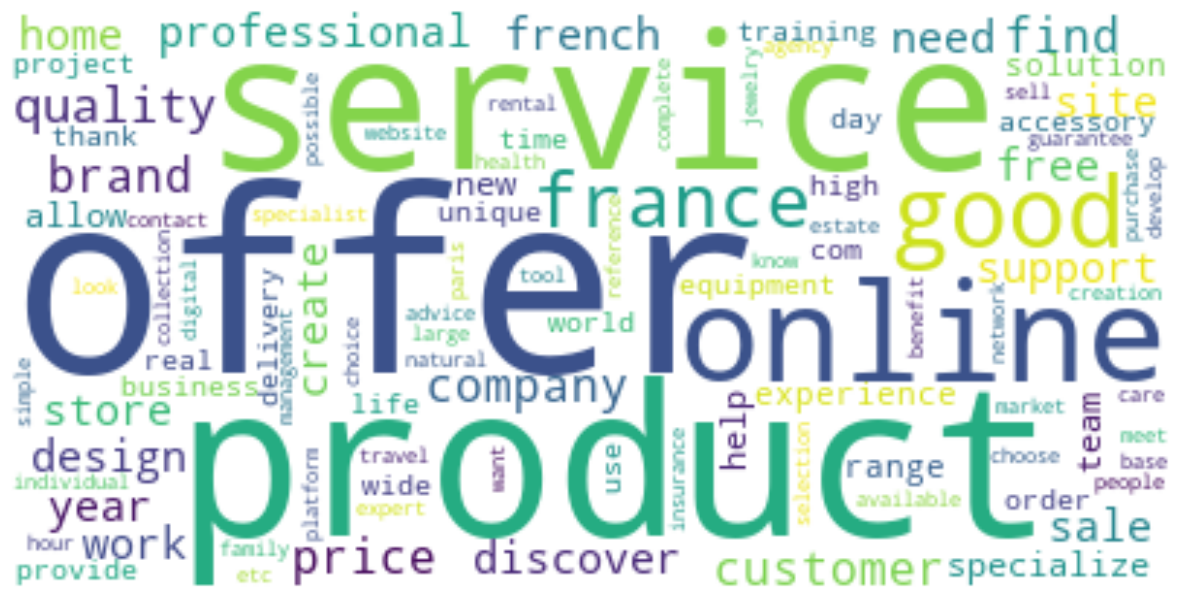

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(company_desc)).value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [21]:
from gensim import corpora

#creating term dictionary
dictionary = corpora.Dictionary(company_desc)

#filter out terms which occurs in less than 4 documents and more than 20% of the documents.
#NOTE: Since we have smaller dataset, we will keep this commented for now.

#dictionary.filter_extremes(no_below=4, no_above=0.2)

#list of few which which can be further removed
stoplist = set('hello and if this can would should could tell ask stop come go')
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)

In [22]:
#print top 50 items from the dictionary with their unique token-id
dict_tokens = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 50]]
print (dict_tokens)

[[['beer', 0], ['bottle', 1], ['charge', 2], ['choose', 3], ['collect', 4], ['com', 5], ['deliver', 6], ['drink', 7], ['fourgon', 8], ['free', 9], ['home', 10], ['juice', 11], ['lefourgon', 12], ['milk', 13], ['niche', 14], ['order', 15], ['place', 16], ['producer', 17], ['return', 18], ['reuse', 19], ['sodas', 20], ['soup', 21], ['spirit', 22], ['store', 23], ['visit', 24], ['wash', 25], ['water', 26], ['wine', 27], ['zerodechet', 28], ['adapt', 29], ['advice', 30], ['allow', 31], ['basis', 32], ['brand', 33], ['card', 34], ['cellar', 35], ['champagne', 36], ['clear', 37], ['coffee', 38], ['comptoir', 39], ['consumer', 40], ['consumption', 41], ['customer', 42], ['delicatessen', 43], ['des', 44], ['desire', 45], ['differentiate', 46], ['discover', 47], ['evening', 48], ['event', 49], ['france', 50]]]


In [23]:
corpus = [dictionary.doc2bow(desc) for desc in company_desc]

word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]

print(word_frequencies)

[[('beer', 1), ('bottle', 1), ('charge', 1), ('choose', 1), ('collect', 1), ('com', 1), ('deliver', 2), ('drink', 1), ('fourgon', 1), ('free', 1), ('home', 2), ('juice', 1), ('lefourgon', 1), ('milk', 1), ('niche', 1), ('order', 1), ('place', 1), ('producer', 1), ('return', 1), ('reuse', 1), ('sodas', 1), ('soup', 1), ('spirit', 1), ('store', 1), ('visit', 1), ('wash', 1), ('water', 1), ('wine', 1), ('zerodechet', 1)], [('beer', 1), ('spirit', 1), ('store', 1), ('wine', 3), ('adapt', 1), ('advice', 1), ('allow', 1), ('basis', 1), ('brand', 1), ('card', 1), ('cellar', 4), ('champagne', 1), ('clear', 1), ('coffee', 1), ('comptoir', 2), ('consumer', 1), ('consumption', 1), ('customer', 1), ('delicatessen', 1), ('des', 2), ('desire', 1), ('differentiate', 1), ('discover', 1), ('evening', 1), ('event', 1), ('france', 1), ('good', 1), ('habit', 1), ('highlight', 1), ('indulgence', 1), ('merchant', 1), ('mission', 1), ('modern', 1), ('money', 1), ('need', 1), ('new', 1), ('offer', 1), ('organ

In [29]:
company_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
company_lsi_model = gensim.models.LsiModel(company_tfidf_model[corpus], id2word=dictionary, num_topics=300)

In [30]:
gensim.corpora.MmCorpus.serialize('semanticsearch_data/company_tfidf_model_mm', company_tfidf_model[corpus])
gensim.corpora.MmCorpus.serialize('semanticsearch_data/company_lsi_model_mm',company_lsi_model[company_tfidf_model[corpus]])

In [31]:
#Load the indexed corpus
company_tfidf_model = gensim.corpora.MmCorpus('semanticsearch_data/company_tfidf_model_mm')
company_lsi_model = gensim.corpora.MmCorpus('semanticsearch_data/company_lsi_model_mm')

print(company_tfidf_model)
print(company_lsi_model)

MmCorpus(11468 documents, 27620 features, 318555 non-zero entries)
MmCorpus(11468 documents, 300 features, 3438900 non-zero entries)


In [32]:
from gensim.similarities import MatrixSimilarity

company_index = MatrixSimilarity(company_lsi_model, num_features = company_lsi_model.num_terms)

In [33]:
from operator import itemgetter

In [34]:
def search_similar_movies(search_term):

    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    query_tfidf = company_tfidf_model[query_bow]
    query_lsi = company_lsi_model[query_tfidf]

    company_index.num_best = 5

    company_list = company_index[query_lsi]

    company_list.sort(key=itemgetter(1), reverse=True)
    company_names = []

    for j, movie in enumerate(company_list):

        company_names.append (
            {
                'Relevance': round((movie[1] * 100),2),
                'Company Name': company_df['company_name'][movie[0]],
                'Company Description': company_df['description_en'][movie[0]]
            }

        )
        if j == (company_index.num_best-1):
            break

    return pd.DataFrame(company_names, columns=['Relevance','Company Name','Company Description'])

In [35]:
# search for movie tiles that are related to below search parameters
search_similar_movies('makeup nails')

ValueError: Unrecognised value for docno, use either a single integer, a slice or a numpy.ndarray

In [5]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop and len(token.text) > 2]

    if len(txt) > 2:
        return ' '.join(txt)

In [6]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in company_df['description_en'])

In [7]:
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

KeyboardInterrupt: 

In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(11365, 1)

In [ ]:
df_clean

,clean
0,fourgon deliver store drink home order place l...
1,comptoir des vigne brand cellar specialize win...
2,welcome trustpilot page shin sekai online figu...
3,nutri naturel com lead online organic grocery ...
4,maison martin piment francais brand artisanal ...
...,...
12991,sale auto body spare part online fender bumper...
12992,aeroport paris platform major connection point...
12993,share host unlimited traffic domain dedicated ...
12994,online specialist sale horse ride equipment sa...


In [ ]:
#creating term dictionary
%time dictionary = corpora.Dictionary(movie_plot)

#filter out terms which occurs in less than 4 documents and more than 20% of the documents.
#NOTE: Since we have smaller dataset, we will keep this commented for now.

#dictionary.filter_extremes(no_below=4, no_above=0.2)

#list of few which which can be further removed
stoplist = set('hello and if this can would should could tell ask stop come go')
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)

In [ ]:
corpus = [dictionary.doc2bow(desc) for desc in movie_plot]
word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]

In [ ]:
movie_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
movie_lsi_model = gensim.models.LsiModel(movie_tfidf_model[corpus], id2word=dictionary, num_topics=300)

#Serialize and Store the corpus locally for easy retrival whenver required.
gensim.corpora.MmCorpus.serialize('movie_tfidf_model_mm', movie_tfidf_model[corpus])
gensim.corpora.MmCorpus.serialize('movie_lsi_model_mm',movie_lsi_model[movie_tfidf_model[corpus]])

#Load the indexed corpus
movie_tfidf_corpus = gensim.corpora.MmCorpus('movie_tfidf_model_mm')
movie_lsi_corpus = gensim.corpora.MmCorpus('movie_lsi_model_mm')

#Load the MatrixSimilarity
from gensim.similarities import MatrixSimilarity
movie_index = MatrixSimilarity(movie_lsi_corpus, num_features = movie_lsi_corpus.num_terms)

In [ ]:
from operator import itemgetter

def search_similar_movies(search_term):

    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    query_tfidf = movie_tfidf_model[query_bow]
    query_lsi = movie_lsi_model[query_tfidf]

    movie_index.num_best = 5

    movies_list = movie_index[query_lsi]

    movies_list.sort(key=itemgetter(1), reverse=True)
    movie_names = []

    for j, movie in enumerate(movies_list):

        movie_names.append (
            {
                'Relevance': round((movie[1] * 100),2),
                'Movie Title': df_movies['title'][movie[0]],
                'Movie Plot': df_movies['wiki_plot'][movie[0]]
            }

        )
        if j == (movie_index.num_best-1):
            break

    return pd.DataFrame(movie_names, columns=['Relevance','Movie Title','Movie Plot'])